# Multimodal Analysis for EEG Data

In [45]:
#IMPORT LIBS

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import mne
import seaborn as sns
import networkx as nx
import scipy
from scipy.stats import kstest, ks_2samp
from scipy import signal
from scipy.signal import butter, lfilter, freqz, hilbert, coherence, filtfilt
from scipy.special import xlogy
import EntropyHub as EH
from scipy import io as sio
from neurodsp.spectral import compute_spectrum, rotate_powerlaw
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score
from fooof import FOOOF
import numpy as np
from scipy import signal
import glob
from sklearn.feature_selection import mutual_info_regression
from neurodsp.timefrequency.wavelets import compute_wavelet_transform
from eeg_fConn import connectivity as con


In [23]:
#LOAD THE rsEEG CONTROL DATA
raw = mne.io.read_raw_edf(r"C:\Users\leona\Leo_Python\control_rest.edf")

# Extract data and channel names
data = raw.get_data()
channel_names_control = raw.ch_names
channel_names_control = channel_names_control[:13]


#print information
print(raw.info)

#remove transient initial data and last channel of control
control = data[:13,100:5700]
control.shape

Extracting EDF parameters from C:\Users\leona\Leo_Python\control_rest.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<Info | 8 non-empty values
 bads: []
 ch_names: C4, P4, F8, T4, Fp1, F3, C3, P3, F7, T3, T5, Fz, Cz, Status
 chs: 13 EEG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2024-05-18 16:50:28 UTC
 nchan: 14
 projs: []
 sfreq: 256.0 Hz
 subject_info: 4 items (dict)
>


(13, 5600)

In [24]:
#LOAD THE rsEEG ASD DATA

raw = mne.io.read_raw_edf(r"C:\Users\leona\Leo_Python\asd_rest.edf")

# Extract data and channel names
data = raw.get_data()
channel_names = raw.ch_names
channel_names = channel_names[:16]
#print information
print(raw.info)

#remove transient initial data and last channel of control
rest = data[:16,200:5800]
rest.shape

Extracting EDF parameters from C:\Users\leona\Leo_Python\asd_rest.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<Info | 8 non-empty values
 bads: []
 ch_names: F3, C3, P3, O1, T3, T5, Fpz, Fz, Cz, Pz, Fp2, F4, C4, P4, O2, ...
 chs: 16 EEG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2024-03-15 14:40:45 UTC
 nchan: 17
 projs: []
 sfreq: 256.0 Hz
 subject_info: 4 items (dict)
>


(16, 5600)

In [17]:
#mask control and asd to match the channels in common C4,P4,T4,F3,C3,P3,T3,T5,Fz,Cz

channel_names_mask = ['C4','P4','T4','F3','C3','P3','T3','T5','Fz','Cz']
mask_c = [0,1,3,5,6,7,9,10,11,12]
mask_asd = [12,13,15,0,1,2,4,5,7,8]
control_mask = np.zeros([10,5600])
rest_mask = np.zeros([10,5600])
#sim_mask = np.zeros([10,5032])
for i in range (10):
    control_mask[i,:] = control[mask_c[i],:]
    rest_mask[i,:] = rest[mask_asd[i],:]
    #sim_mask[i,:] = simulation__[mask_asd[i],:]


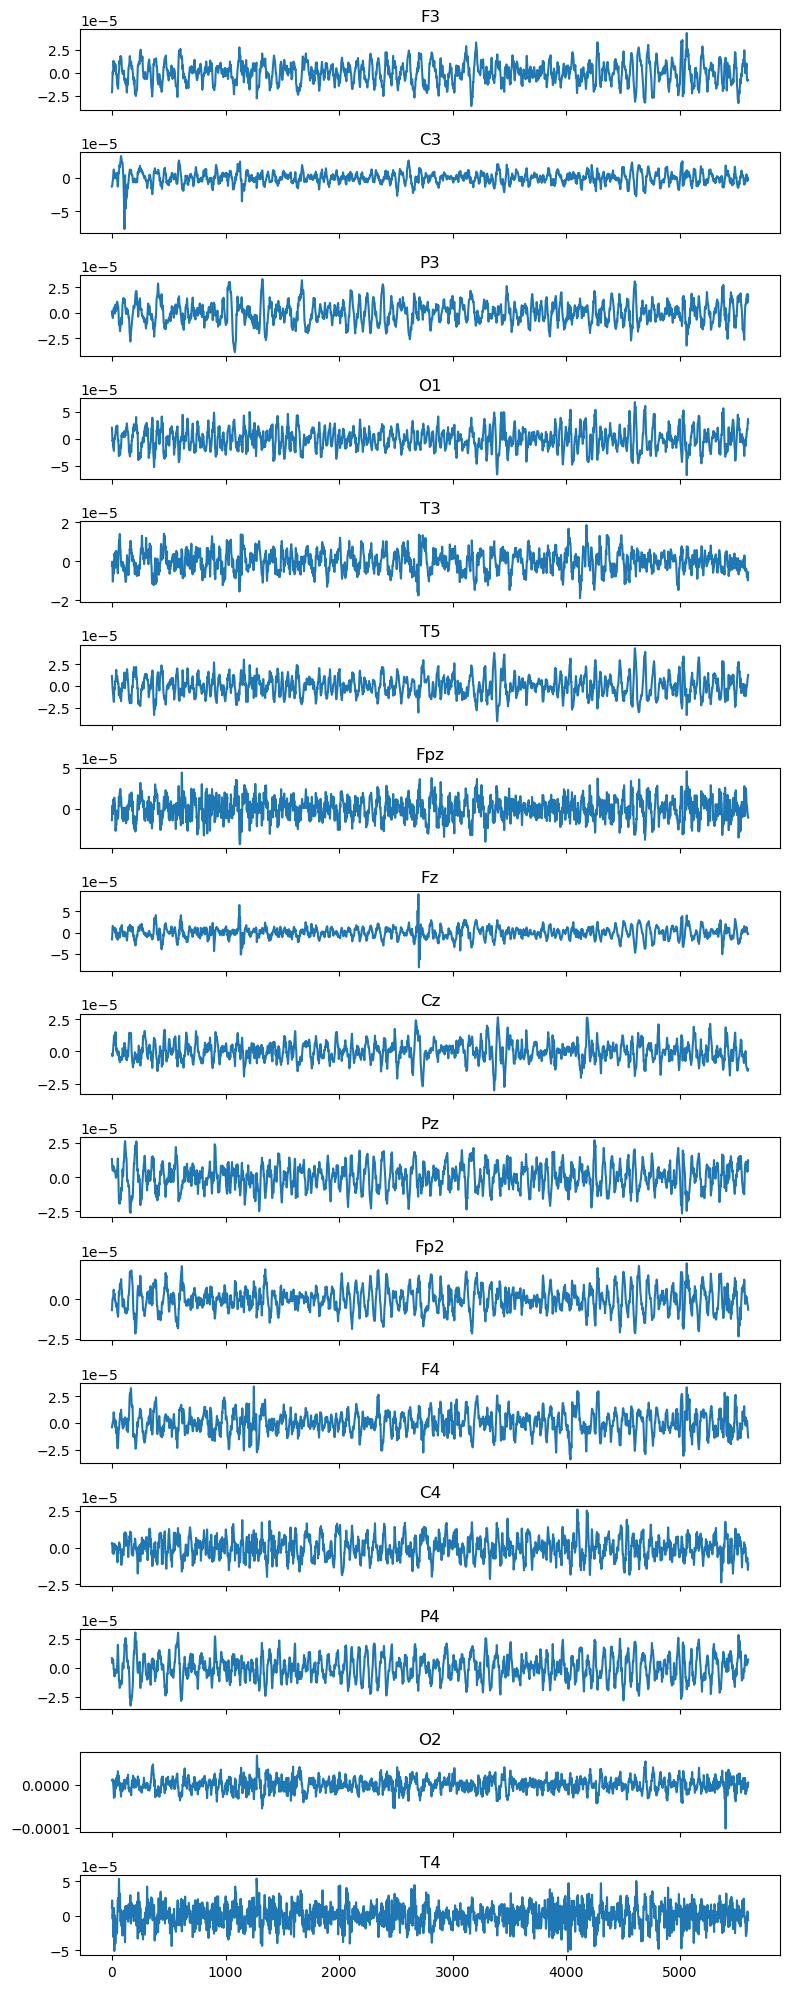

In [19]:
#plot raw data for each channel for visual inspection

fig, axs = plt.subplots(16, sharex = 'all', figsize = (8,20))

for i, ax in enumerate(axs.flatten()):
        ax.plot(rest[i,:])
        ax.set_title(str(channel_names[i]))
plt.tight_layout()
plt.show()

## Functional Connectivity Analysis

Text(0.5, 1.0, 'Difference')

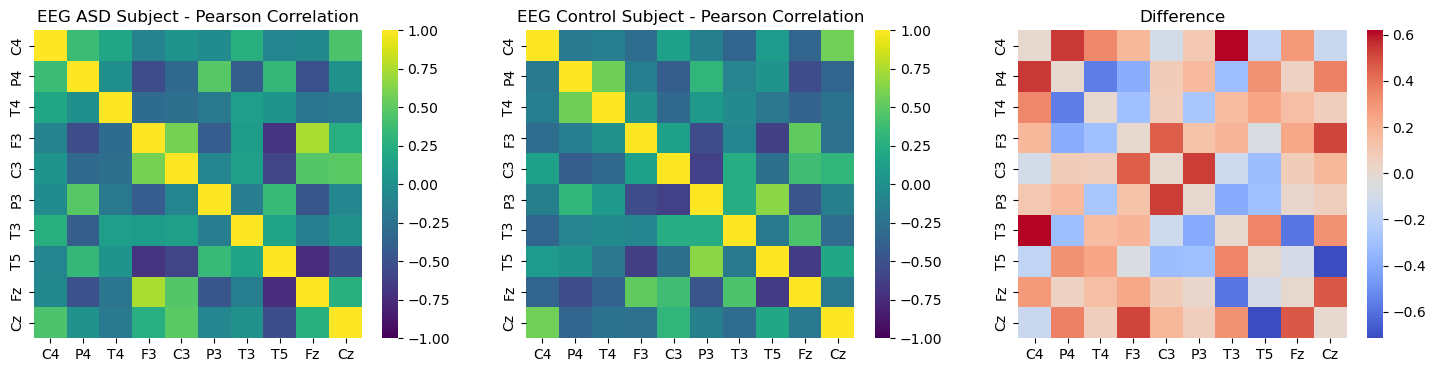

In [33]:
#PEARSON CORRELATION

plt.figure(figsize = (18,4))

plt.subplot(1,3,1)

corr_asd_mask = pd.DataFrame(data=rest_mask[:, :]).T.corr()
#mask = np.triu(np.ones_like(corr_asd_mask, dtype=bool))
#ax = plt.axes()
sns.heatmap(data=corr_asd_mask, vmin=-1, vmax=1, cmap='viridis', xticklabels = channel_names_mask , yticklabels =channel_names_mask )
plt.title('EEG ASD Subject - Pearson Correlation')

plt.subplot(1,3,2)


corr_control_mask = pd.DataFrame(data=control_mask[:, :]).T.corr()
#mask = np.triu(np.ones_like(corr_control_mask, dtype=bool))
#ax = plt.axes()
sns.heatmap(data=corr_control_mask, vmin=-1, vmax=1, cmap='viridis', xticklabels = channel_names_mask , yticklabels =channel_names_mask )#, mask = mask)
plt.title('EEG Control Subject - Pearson Correlation')

plt.subplot(1,3,3)


#mask = np.triu(np.ones_like(corr_control_mask, dtype=bool))
#ax = plt.axes()
sns.heatmap(data=corr_asd_mask - corr_control_mask,  cmap='coolwarm', xticklabels = channel_names_mask , yticklabels =channel_names_mask )#, mask = mask)
plt.title('Difference')

In [44]:
#PHASE LAG INDEX

data=rest
ch_names = channel_names
n_channels = data.shape[0]
filtered_data = con.filteration(data=data[:, :], f_min=1, f_max=40, fs=256)

# pli connectivity
phase_lag,V = con.pli_connectivity(sensors=n_channels,data=filtered_data)
phase_lag.shape

#plot
ax = plt.axes()
mask = np.triu(np.ones_like(phase_lag, dtype=bool))
sns.heatmap(data=phase_lag, cmap='bwr', vmin=0, vmax=0.96,  xticklabels = ch_names, yticklabels = ch_names)#, mask = mask) # mettere label al colorbar, ed elimina ridondanza matrice triangolare
ax.set_title('EEG Data Recordings - Phase Lag Index Matrix')

In [ ]:
# PHASE LOCKING VALUE

phase_lock,W = con.plv_connectivity(sensors=16,data=filtered_data)  #scala logaritmica valori, o sulla matrice, o con funzione norm sul colore
mask = np.triu(np.ones_like(phase_lock, dtype=bool))
ax = plt.axes()
sns.heatmap(data=phase_lock, cmap='bwr', vmin=0.3, vmax=0.7,  xticklabels = channel_names, yticklabels = channel_names, mask = mask)
ax.set_title('EEG Data Recordings - Phase Locking Value Matrix')

In [ ]:
# COHERENCE

coh,V = con.coh_connectivity(sensors=16, data=rest[:, :], f_min=8, f_max=12, fs=250)
mask = np.triu(np.ones_like(coh, dtype=bool))
ax = plt.axes()
sns.heatmap(coh,  vmin=0, vmax=1, cmap='bwr', xticklabels = channel_names, yticklabels = channel_names, mask = mask)
ax.set_title('EEG Data Recordings - Coherence Matrix')

In [ ]:
# MUTUAL INFORMATION

mutual_inf_d = np.zeros([n_ch,n_ch])

for i in range (n_ch):
    for j in range (n_ch):
        mutual_inf_d[i,j] = mutual_info_regression(rest[i,:].reshape(-1,1), rest[j,:])

for i in range (n_ch):
    mutual_inf_d[i,i] = 0

## Spectral Analysis

In [ ]:
# compute the PSD of the data and the extract periodic and aperiodic compents with FOOOF algorithm
#compute PSD with Welch's method via median average, the signal must be in the form [n_channels,n_points]

def PSD(data):
    
    n_channels = data.shape[0]
    fs = 256
    f, spec = signal.welch(data[0,:],fs = fs,nperseg = 1024)
    f_nyq = spec.shape[0]
    spectrum = np.zeros([f_nyq ,n_channels])
    for i in range (n_channels):
        f, spectrum[:,i] = signal.welch(data[i,:],fs = fs, average = 'median',nperseg = 1024)

    spectrum = spectrum[:160,:]
    f = f[:160]
    spectrum_mean = spectrum.mean(axis = 1)
    spectrum_max = spectrum_mean.max()
    spectrum_norm = spectrum_mean/spectrum_max

    return spectrum_norm


# COMPUTE PERIODIC AND APERIODIC COMPONENTS OF THE PSD

def PSD_COMPONENTS(psd):
    fs = 256
    f, spec = signal.welch(rest[0,:],fs = fs, nperseg = 512)
    f = f[:80]
    alpha = np.zeros([5075])
    peak = np.zeros([5075])
    n_p = np.zeros([5075])
    for i in range (5075):
         if psd[0,i] > 0:
            # Initialize FOOOF object
            fm = FOOOF()#aperiodic_mode='knee')
            # Define frequency range across which to model the spectrum
            freq_range = [1, 40]
            # Model the power spectrum with FOOOF, and print out a report
            #fm.report(f, spectrum_norm, freq_range)
            fm.fit(f, psd[:,i], freq_range)
            #extract aperiodic component
            alpha[i] = fm.aperiodic_params_[1]
            #and periodic component (first peak in the PSD)
            p = fm.peak_params_
            n_p[i] = fm.n_peaks_
            if n_p[i] > 0:
                peak[i] = p[0,0]
    return peak, alpha

#print out a report
fm = FOOOF()#aperiodic_mode='knee')
fm.report(f, spectrum_norm, freq_range)

In [47]:
# compute and plot morlet wavelet for each channel of the simulated eeg data

for i in range(n_channels):
    freqs = np.linspace(1, 20, 200)
    n_seconds = 22
    var = channel_names[i]
    sig_rest_ch=  rest[i,:]
    times = create_times(n_seconds, fs)
    # Compute wavelet transform using compute Morlet wavelet transform algorithm
    mwt = compute_wavelet_transform(sig_rest_ch, fs=fs, n_cycles=15, freqs=freqs)
    plot_timefrequency(times, freqs, mwt)
    plt.title('Morlet Wavelet on channel '+ str(var) , fontsize = 14)

## Complexity Analysis

In [ ]:
#Compute randomness of the series with ApproximateEntropy and SampleEntropy

n_channels = rest.shape[0]
ApEn_rest = np.zeros([3,n_channels])
SampEn_rest = np.zeros([3,n_channels])

for i in range (n_channels):
    ApEn_rest[:,i], K = EH.ApEn(rest[i,:])
    SampEn_rest[:,i], J, K = EH.SampEn(rest[i,:])

n_channels = control.shape[0]
ApEn_rest_c = np.zeros([3,n_channels])
SampEn_rest_c = np.zeros([3,n_channels])

for i in range (n_channels):
    ApEn_rest_c[:,i], K = EH.ApEn(control[i,:])
    SampEn_rest_c[:,i], J, K = EH.SampEn(control[i,:])


In [ ]:
#comparison between asd and control

ap_entropies = np.zeros([10,2,3])
for i in range (3):
    ap_entropies[:,0,i] = ApEn_rest_c[i,:]
    ap_entropies[:,1,i] = ApEn_rest[i,:]

ap_entropies[2,1,2] = 'Nan'

# build a dataframe object and plot box and swarm
subjects = ['Healthy Subject','ASD Subject']
for i in range (2,3):
    df = pd.DataFrame(ap_entropies[:,:,i], columns = subjects) 
    colors = ['#24838d','#e96d13']
    sns.violinplot(data=df, palette = colors, inner = None, saturation = 0.85)
    ap_entropies[2,1,2] = 0.9828505421154081
    sns.swarmplot(data=df, color='black')
    plt.title('Approximate Entropy Comparison')
    plt.ylabel('ApEn of EEG channels')
    plt.ylim(0.3,1.2)
    plt.xlim(-0.5,1.5)
    # statistical annotation
    x1, x2 = 0,1 
    y, h, col = 1.05, 0.05, 'k'

    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, "* pvalue=0.00018", ha='center', va='bottom', color=col)
    plt.show()

## Topological Data Analysis

In [ ]:
# takens time delay embedding > persistence diagram > bettic curves > statistics: (persistence entropy, betti max)

series = rest
time_delay = 40
embedding_dimension = 40
stride = 4
embedder = SingleTakensEmbedding(
    parameters_type="search", time_delay=time_delay, dimension=embedding_dimension, stride = stride
)
def fit_embedder(embedder: SingleTakensEmbedding, y: np.ndarray, verbose: bool=True) -> np.ndarray:
    """Fits a Takens embedder and displays optimal search parameters."""
    y_embedded = embedder.fit_transform(y)

    if verbose:
        print(f"Shape of embedded time series: {y_embedded.shape}")
        print(
            f"Optimal embedding dimension is {embedder.dimension_} and time delay is {embedder.time_delay_}"
        )

    return y_embedded
n_ch = series.shape[0]
entropy = np.zeros([3,n_ch])
betti_max = np.zeros([3,n_ch])
for i in range (n_ch):
    x = series[i,:]
    x_embedded = fit_embedder(embedder, x)
    homology_dimensions = [0, 1, 2]

    persistence = VietorisRipsPersistence(
        homology_dimensions=homology_dimensions, n_jobs=6)
    diagramScaler = Scaler()
    diagramFiltering = Filtering(epsilon=0.1, homology_dimensions=(1, 2))
    PE = PersistenceEntropy()
    w_embedded = x_embedded[None, :, :]
    diagrams_w= persistence.fit_transform_plot(w_embedded)
    W_scaled = diagramScaler.fit_transform(diagrams_w)
    W_filtered = diagramFiltering.fit_transform(W_scaled)
    W_persistence_entropy = PE.fit_transform(W_filtered)
    entropy[:,i] = W_persistence_entropy
    BC = BettiCurve()
    W_betti_curves = BC.fit_transform(W_filtered) 
    for j in range (3):
            betti_max[j,i] = W_betti_curves[0,j,:].max()
entropy, betti_max